# Document Purpose:
* exploratory data analysis
* Baseline ML Model with Evaluation: PREDICT percent change in stock price after next earnings event for all company

# Imports

In [45]:
## data cleaning/analysis
import pandas as pd
import numpy as np
from scipy.stats import zscore

## Vizzes
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# modeling:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree, export_text
# conda install 
# import graphviz


In [2]:
data = pd.read_csv("data/data_full.csv")

In [3]:
data

date symbol                                  security_name  \
0     2023-01-03    SGH  SMART Global Holdings, Inc. - Ordinary Shares   
1     2023-01-04    RGP      Resources Connection, Inc. - Common Stock   
2     2023-01-04    SLP          Simulations Plus, Inc. - Common Stock   
3     2023-01-05    CAG              ConAgra Brands, Inc. Common Stock   
4     2023-01-05   HELE           Helen of Troy Limited - Common Stock   
...          ...    ...                                            ...   
6153  2023-12-20    GIS               General Mills, Inc. Common Stock   
6154  2023-12-20    TTC                Toro Company (The) Common Stock   
6155  2023-12-21   CTAS              Cintas Corporation - Common Stock   
6156  2023-12-21   LMNR                    Limoneira Co - Common Stock   
6157  2023-12-21   PAYX                   Paychex, Inc. - Common Stock   

     before_eps_date after_eps_date   Adj Close       Close  \
0         2023-01-03     2023-01-04   15.750000   15.750000   
1         2023-01-04     2023-01-05   14.715991   15.420000   
2         2023-01-04     2023-01-05   34.700558   34.959999   
3         2023-01-04     2023-01-05   37.901043   39.970001   
4         2023-01-04     2023-01-05  110.970001  110.970001   
...              ...            ...         ...         ...   
6153      2023-12-19     2023-12-20   64.330002   64.330002   
6154      2023-12-19     2023-12-20   96.855721   97.209999   
6155      2023-12-20     2023-12-21  588.635681  589.950012   
6156      2023-12-21     2023-12-22   20.435904   20.510000   
6157      2023-12-20     2023-12-21  118.039871  118.900002   

      Adj Close_pct_change  Close_pct_change  EPS Estimate  Reported EPS  \
0                 0.041667          0.041667          0.57          0.79   
1                -0.171858         -0.171858          0.47          0.59   
2                -0.070954         -0.070954          0.09          0.06   
3                 0.034153          0.034153          0.66          0.81   
4                -0.014301         -0.014301          2.61          2.75   
...                    ...               ...           ...           ...   
6153             -0.035677         -0.035677          1.16          1.25   
6154              0.089432          0.089432          0.56          0.71   
6155              0.065546          0.065546          3.49          3.61   
6156              0.068786          0.068786         -0.15         -0.15   
6157             -0.070077         -0.070077          1.07          1.08   

      Surprise(%)  
0          0.3831  
1          0.2553  
2         -0.2941  
3          0.2193  
4          0.0551  
...           ...  
6153       0.0823  
6154       0.2747  
6155       0.0332  
6156       0.0196  
6157       0.0056  

[6158 rows x 12 columns]

In [4]:
# dataset with only numeric columns, dates excluded 
# Remove AjClose and Adj Close Pct Change (no significant difference visually between the two)
data_num = data[['Close', 'Close_pct_change',
       'EPS Estimate', 'Reported EPS', 'Surprise(%)']].copy()
data_num

Close  Close_pct_change  EPS Estimate  Reported EPS  Surprise(%)
0      15.750000          0.041667          0.57          0.79       0.3831
1      15.420000         -0.171858          0.47          0.59       0.2553
2      34.959999         -0.070954          0.09          0.06      -0.2941
3      39.970001          0.034153          0.66          0.81       0.2193
4     110.970001         -0.014301          2.61          2.75       0.0551
...          ...               ...           ...           ...          ...
6153   64.330002         -0.035677          1.16          1.25       0.0823
6154   97.209999          0.089432          0.56          0.71       0.2747
6155  589.950012          0.065546          3.49          3.61       0.0332
6156   20.510000          0.068786         -0.15         -0.15       0.0196
6157  118.900002         -0.070077          1.07          1.08       0.0056

[6158 rows x 5 columns]

### outliers detection:

In [5]:

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = data_num.quantile(0.25)
Q3 = data_num.quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = data_num[((data_num < lower_bound) | (data_num > upper_bound)).any(axis=1)]

print("Outliers:")
outliers

Outliers:


Close  Close_pct_change  EPS Estimate  Reported EPS  Surprise(%)
1      15.420000         -0.171858          0.47          0.59       0.2553
5     161.860001          0.033325          1.18          1.65       0.3983
6      96.029999          0.097737          0.74          1.28       0.7231
9       2.170000          0.043269         -0.06         -0.28      -3.4213
10    174.649994          0.028805          3.01          3.29       0.0947
...          ...               ...           ...           ...          ...
6144  250.000000          0.038551          2.39          2.46       0.0272
6146    5.940000          0.093923         -0.07          0.37       6.2857
6149  162.490005         -0.003679          1.74          1.84       0.0605
6150  341.510010         -0.000995          3.14          3.27       0.0401
6155  589.950012          0.065546          3.49          3.61       0.0332

[2343 rows x 5 columns]

In [6]:
# Drop outliers
df_no_out = data_num.drop(outliers.index).reset_index(drop=True)

print("DataFrame after dropping outliers:")
df_no_out

DataFrame after dropping outliers:


Close  Close_pct_change  EPS Estimate  Reported EPS  Surprise(%)
0      15.750000          0.041667          0.57          0.79       0.3831
1      34.959999         -0.070954          0.09          0.06      -0.2941
2      39.970001          0.034153          0.66          0.81       0.2193
3     110.970001         -0.014301          2.61          2.75       0.0551
4      77.029999         -0.054847          1.46          1.48       0.0126
...          ...               ...           ...           ...          ...
3810    1.270000         -0.030534         -0.14         -0.13       0.0730
3811   64.330002         -0.035677          1.16          1.25       0.0823
3812   97.209999          0.089432          0.56          0.71       0.2747
3813   20.510000          0.068786         -0.15         -0.15       0.0196
3814  118.900002         -0.070077          1.07          1.08       0.0056

[3815 rows x 5 columns]

### Missing Values

In [7]:
missing_val = df_no_out[["Close","Close_pct_change", "EPS Estimate","Reported EPS"]].copy()
index_to_drop = missing_val.loc[missing_val.isna().any(axis = 1), :].index

# leaving Surprise NaN's for EDA

In [8]:
# drop rows with missing values 
df_clean = df_no_out.drop(index_to_drop).reset_index(drop = True).copy()

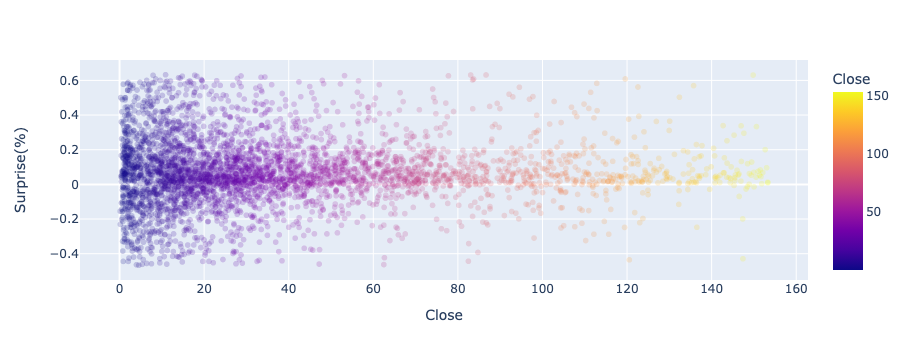

In [9]:
# plot reported EPS and EPS estimate, add close value of stock price as hue
# x and y given as array_like objects
import plotly.express as px
x_vals = df_clean['EPS Estimate']
y_vals = df_clean['Reported EPS']

# fig = px.scatter(x=x_vals, y=y_vals)


fig = px.scatter(df_clean, x="Close", y="Surprise(%)", color="Close", opacity = .2)
fig.show()

# EDA

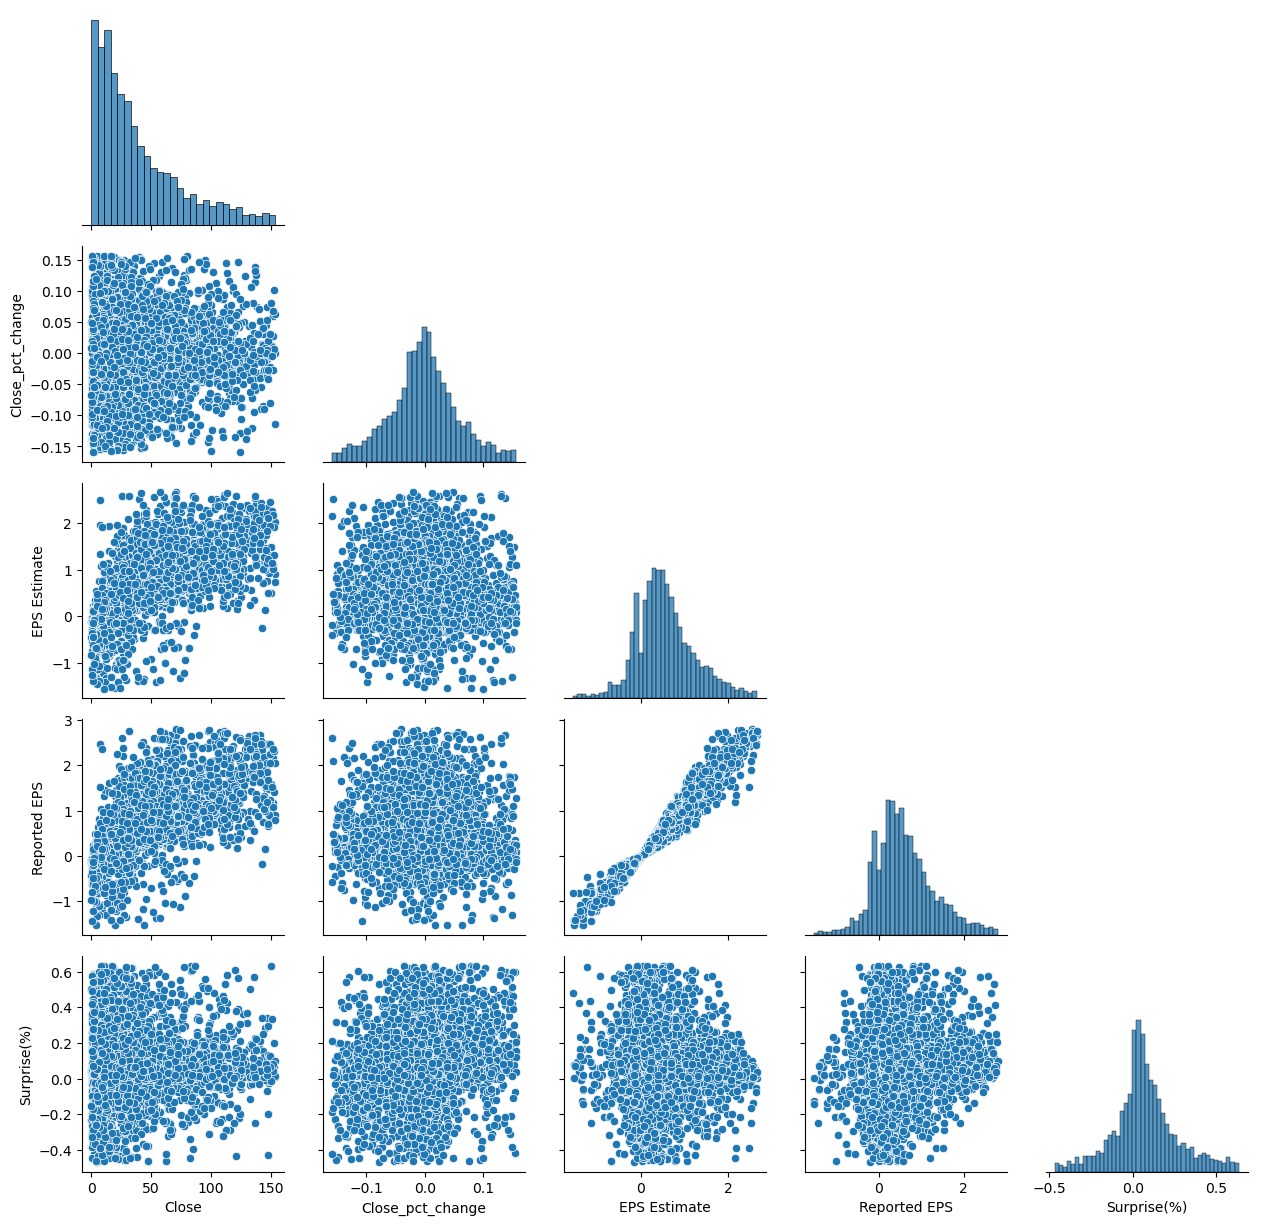

In [10]:
g = sns.PairGrid(df_clean,corner=True)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

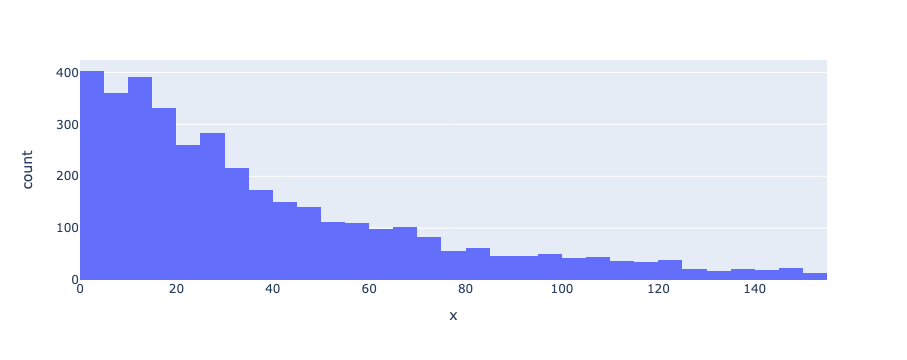

In [11]:
# Create histogram
fig = px.histogram(x=df_clean['Close'])

# Show plot
fig.show()

# remove outliers

<Axes: >

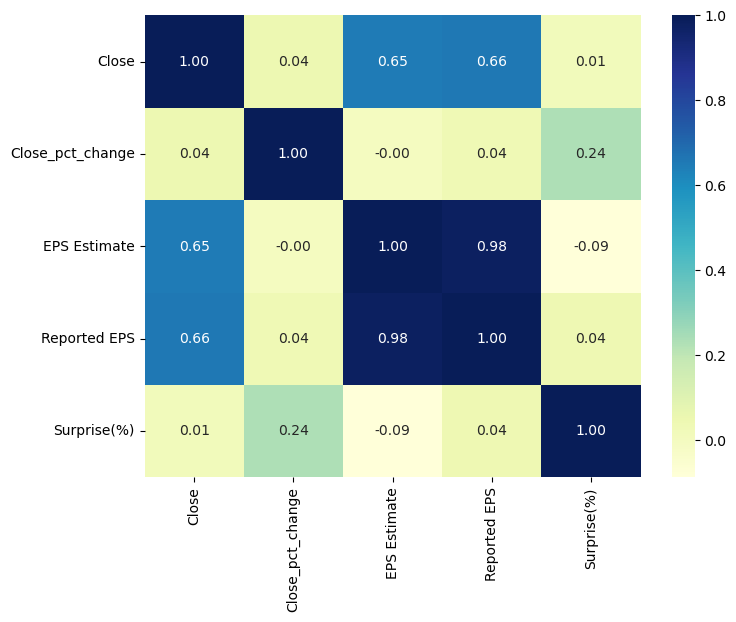

In [12]:
# correlation matrix outliers removed: 
plt.figure(figsize=(8, 6))
corr_matrix = df_clean.corr(numeric_only=True)


sns.heatmap(corr_matrix, cmap="YlGnBu", annot=True, fmt='.2f', annot_kws={'size': 10})


<Axes: >

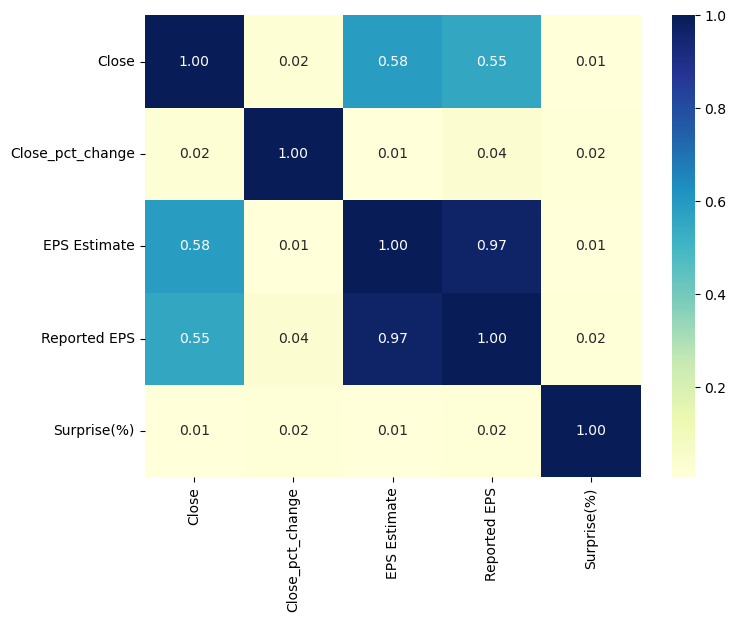

In [13]:
# correlation matrix outliers not removed
plt.figure(figsize=(8, 6))
corr_matrix = data_num.corr(numeric_only=True)


sns.heatmap(corr_matrix, cmap="YlGnBu", annot=True, fmt='.2f', annot_kws={'size': 10})


# Modelling

### Stock Price and Percent Change after Earnings Event
Project goal was specifically to develop a model that predicted the percent change of and Earnings Event based on the the stock price. 

The scatter plot below shows the relationship between closing stock price and the percent change. 

From the correlation heat map above, the correlation coefficient (CC) between closing stock price and percent change in stock price after earnings event is **0.04**. CC value was 0.02, removed outliers, CC became 0.04.
Correlation coefficients values ranges from -1 to 1, where:

* 1 indicates a perfect positive linear relationship,
* -1 indicates a perfect negative linear relationship, and
* 0 indicates no linear relationship between the variables.

As a result of the CC, the model may struggle to make reliable or useful predictions. 

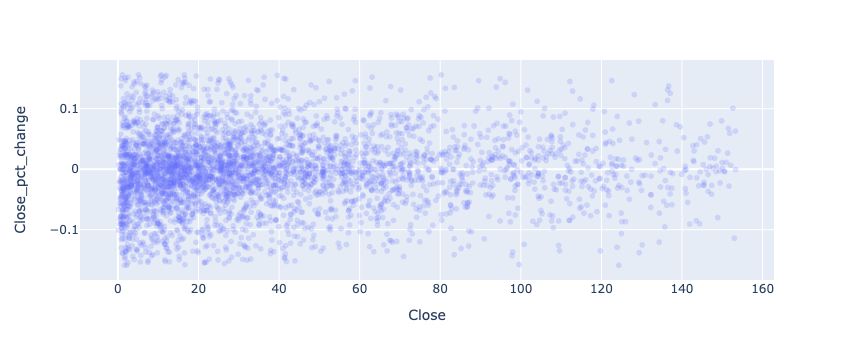

In [14]:
# x and y given as array_like objects
import plotly.express as px

fig = px.scatter(df_clean, x="Close", y="Close_pct_change", opacity = .2)
fig.show()

## Baseline Statistical Model
(no predicitons)

In [158]:
import statsmodels.api as sm

In [160]:
mod = sm.OLS(y, X)

res = mod.fit()

print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:       Close_pct_change   R-squared (uncentered):                   0.041
Model:                            OLS   Adj. R-squared (uncentered):              0.040
Method:                 Least Squares   F-statistic:                              53.86
Date:                Tue, 12 Mar 2024   Prob (F-statistic):                    4.39e-34
Time:                        15:44:37   Log-Likelihood:                          5458.3
No. Observations:                3787   AIC:                                 -1.091e+04
Df Residuals:                    3784   BIC:                                 -1.089e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

#### Interpretation: 
Based on this statistical model, 
* the **close pvalue of 0.793** indicates that it is not a statistically significant predictor of percent change in stock price. 
* The **Adjusted R-Square value of 0.040** means that the input variables  explain 4% of the patterns in the target variable (the stock price percentage change)

## Baseline: Linear Regression

Develop a baseline linear regression model that predicts percent change in stock price based on Closing stock price, EPS Estimate and Reported EPS

In [15]:
df_clean

Close  Close_pct_change  EPS Estimate  Reported EPS  Surprise(%)
0      15.750000          0.041667          0.57          0.79       0.3831
1      34.959999         -0.070954          0.09          0.06      -0.2941
2      39.970001          0.034153          0.66          0.81       0.2193
3     110.970001         -0.014301          2.61          2.75       0.0551
4      77.029999         -0.054847          1.46          1.48       0.0126
...          ...               ...           ...           ...          ...
3782    1.270000         -0.030534         -0.14         -0.13       0.0730
3783   64.330002         -0.035677          1.16          1.25       0.0823
3784   97.209999          0.089432          0.56          0.71       0.2747
3785   20.510000          0.068786         -0.15         -0.15       0.0196
3786  118.900002         -0.070077          1.07          1.08       0.0056

[3787 rows x 5 columns]

In [16]:
# split target (what we are trying to predict, Y) and features (independent variables, X)
y = df_clean['Close_pct_change'].copy()
X = df_clean[['Close','EPS Estimate', 'Reported EPS']].copy() # not including surprise since it is calculated using EPS Estimate and Reported EPS


In [17]:
# shuffle : 
X, y = shuffle(X, y, random_state = 27)

In [18]:
# make train and evaluate (test) split:

train_ratio = 0.7


In [19]:
# make train and evaluate (test) split:

train_ratio = 0.7
X_train, X_eval, y_train, y_eval = train_test_split(X, y, shuffle = False, train_size = train_ratio)

print(f'{len(X_train)} training samples and {len(X_eval)} evaluation(test) samples')

2650 training samples and 1137 evaluation(test) samples


In [20]:
# train model : 
reg = LinearRegression()
reg.fit(X_train, y_train)


LinearRegression()

In [21]:
## Evaluate performance of the model : 
y_train_pred = reg.predict(X_train)
y_eval_pred = reg.predict(X_eval)

r2_train = r2_score(y_train, y_train_pred)
r2_eval = r2_score(y_eval, y_eval_pred)

print(f'Train R^2:\t {r2_train}\nEval R^2:\t {r2_eval}')

Train R^2:	 0.045941591846283214
Eval R^2:	 0.04060487947915181


Proportion of the variation in dependent variable Y, that can be explained by independent variables. 
low only 0.04% 

In [102]:
# Mean Absolute Error:

LR_MAE_train = mean_absolute_error(y_train, y_train_pred) 
LR_MAE_eval = mean_absolute_error(y_eval, y_eval_pred) 

print(f'MAE Train:\t {LR_MAE_train}\nMAE Eval:\t {LR_MAE_eval}')


MAE Train:	 0.04384850065614829
MAE Eval:	 0.043927343782194414


In [23]:
# X_train
# X_eval

# y_train
y_eval
# y_eval_pred
# y_train_pred

1889   -0.003802
1709   -0.003096
1051    0.123302
2126   -0.037694
2839   -0.085973
          ...   
1317   -0.052000
752    -0.006677
2591   -0.007547
3768   -0.120470
1043   -0.026891
Name: Close_pct_change, Length: 1137, dtype: float64

In [24]:
y_eval_pred = pd.DataFrame(y_eval_pred, columns = ['y_eval_pred_pct_stock_change'])

In [25]:
# y_eval
# type(y_eval)
y_eval = pd.DataFrame(y_eval).reset_index(drop=True)


In [26]:
y_eval

Close_pct_change
0            -0.003802
1            -0.003096
2             0.123302
3            -0.037694
4            -0.085973
...                ...
1132         -0.052000
1133         -0.006677
1134         -0.007547
1135         -0.120470
1136         -0.026891

[1137 rows x 1 columns]

In [27]:
X_eval = X_eval.reset_index(drop = True).copy()

In [29]:
# type(X_eval)
type(y_eval_pred)
# y_eval_pred = pd.Series(y_eval_pred, name = 'y_eval_pred')
y_eval_pred

y_eval_pred_pct_stock_change
0                        -0.010553
1                        -0.004979
2                         0.004678
3                        -0.006677
4                        -0.012226
...                            ...
1132                      0.014505
1133                      0.005212
1134                     -0.007274
1135                     -0.007644
1136                      0.006826

[1137 rows x 1 columns]

In [30]:
eval = pd.concat([X_eval, y_eval, y_eval_pred], axis = 1)
eval

Close  EPS Estimate  Reported EPS  Close_pct_change  \
0      18.340000          0.59          0.56         -0.003802   
1       3.220000          0.09          0.11         -0.003096   
2     128.179993          0.60          0.66          0.123302   
3      39.060001          0.88          0.89         -0.037694   
4      24.240000         -1.02         -1.14         -0.085973   
...          ...           ...           ...               ...   
1132   56.880001          0.93          1.16         -0.052000   
1133   40.169998          1.63          1.80         -0.006677   
1134    2.630000         -0.04         -0.05         -0.007547   
1135    8.980000          0.16          0.15         -0.120470   
1136   93.000000          0.18          0.27         -0.026891   

      y_eval_pred_pct_stock_change  
0                        -0.010553  
1                        -0.004979  
2                         0.004678  
3                        -0.006677  
4                        -0.012226  
...                            ...  
1132                      0.014505  
1133                      0.005212  
1134                     -0.007274  
1135                     -0.007644  
1136                      0.006826  

[1137 rows x 5 columns]

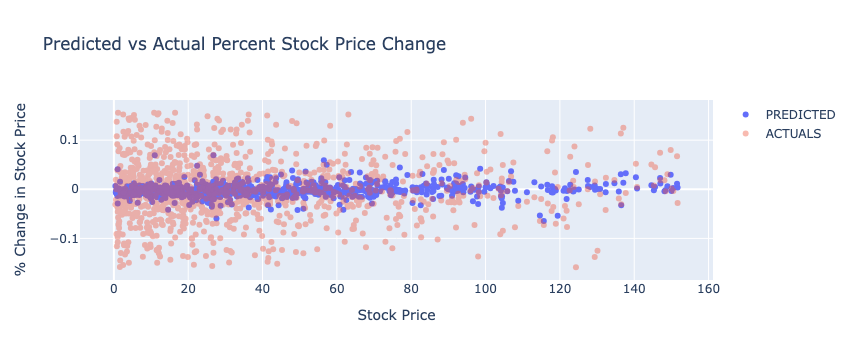

In [32]:
fig = go.Figure()
# Add traces
fig.add_trace(go.Scatter(x=eval['Close'], y=eval['y_eval_pred_pct_stock_change'], 
                    mode='markers',
                    name='PREDICTED', ))
fig.add_trace(go.Scatter(x=eval['Close'], y=eval['Close_pct_change'],opacity = 0.4,
                    mode='markers',
                    name='ACTUALS'))
fig.update_layout(
    title="Predicted vs Actual Percent Stock Price Change",
    xaxis_title="Stock Price",
    yaxis_title="% Change in Stock Price")

fig.show()

## Regression Tree

Attempt making prediction using regression tree instead. Known for being able to make predictions for non-linear data. 

In [56]:
feature = X.columns.tolist()
feature

['Close', 'EPS Estimate', 'Reported EPS']

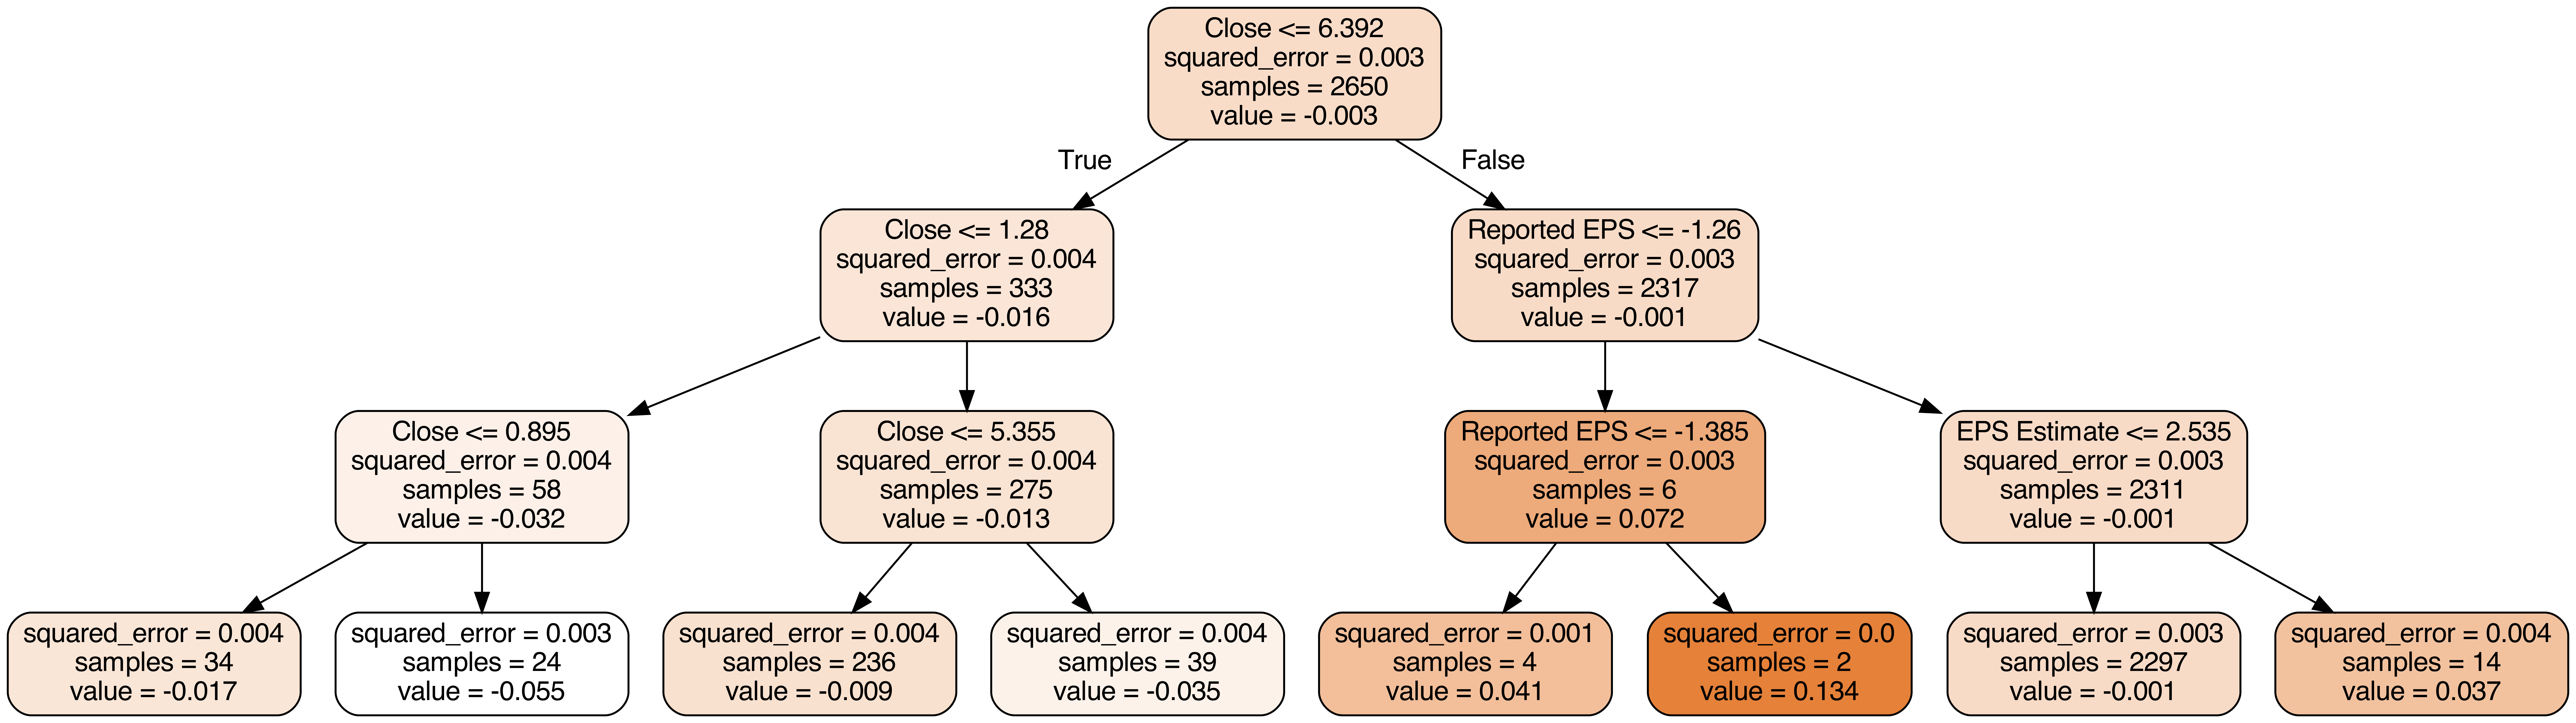

In [64]:
## No train / eval split

import graphviz
# train decision Tree regressor
dt = DecisionTreeRegressor(max_depth = 3)
model = dt.fit(X_train,y_train)


# view decision Tree
graphviz.Source(export_graphviz(model,
                                out_file='tree.dot',
                                feature_names=feature, rounded = True, proportion = False, 
                precision = 3, filled = True))

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=700'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

In [65]:
print(export_text(dt, feature_names = feature,  show_weights=True))

|--- Close <= 6.39
|   |--- Close <= 1.28
|   |   |--- Close <= 0.89
|   |   |   |--- value: [-0.02]
|   |   |--- Close >  0.89
|   |   |   |--- value: [-0.05]
|   |--- Close >  1.28
|   |   |--- Close <= 5.36
|   |   |   |--- value: [-0.01]
|   |   |--- Close >  5.36
|   |   |   |--- value: [-0.03]
|--- Close >  6.39
|   |--- Reported EPS <= -1.26
|   |   |--- Reported EPS <= -1.38
|   |   |   |--- value: [0.04]
|   |   |--- Reported EPS >  -1.38
|   |   |   |--- value: [0.13]
|   |--- Reported EPS >  -1.26
|   |   |--- EPS Estimate <= 2.53
|   |   |   |--- value: [-0.00]
|   |   |--- EPS Estimate >  2.53
|   |   |   |--- value: [0.04]



In [66]:
y_eval_pred = model.predict(X_eval)

In [70]:
### EVAL (test)
mae_eval  = mean_absolute_error(y_eval, y_eval_pred)
mae_eval

print(f'Regression Tree: The mean absolute error for the evaluation data set is {mae_eval.round(4)}')

The mean absolute error for the evaluation data set is 0.0439


In [72]:
## get MAE for TRAIN data set 
y_train_pred = model.predict(X_train)

### EVAL (test)
mae_train  = mean_absolute_error(y_train, y_train_pred)
mae_train

print(f'Regression Tree: The mean absolute error for the evaluation data set is {mae_train.round(4)}')

The mean absolute error for the evaluation data set is 0.0438


In [126]:
y_train_pred = pd.Series(y_train_pred, name = 'y_train_pred_pct_change')
y_train_pred

0      -0.001104
1      -0.001104
2      -0.001104
3      -0.001104
4      -0.001104
          ...   
2645   -0.016806
2646   -0.001104
2647   -0.001104
2648   -0.001104
2649   -0.001104
Name: y_train_pred_pct_change, Length: 2650, dtype: float64

In [96]:
results_eval = pd.concat([X_eval, y_eval, y_eval_pred], axis = 1)
results_eval

Close  EPS Estimate  Reported EPS  Close_pct_change  \
0      18.340000          0.59          0.56         -0.003802   
1       3.220000          0.09          0.11         -0.003096   
2     128.179993          0.60          0.66          0.123302   
3      39.060001          0.88          0.89         -0.037694   
4      24.240000         -1.02         -1.14         -0.085973   
...          ...           ...           ...               ...   
1132   56.880001          0.93          1.16         -0.052000   
1133   40.169998          1.63          1.80         -0.006677   
1134    2.630000         -0.04         -0.05         -0.007547   
1135    8.980000          0.16          0.15         -0.120470   
1136   93.000000          0.18          0.27         -0.026891   

      y_eval_pred_pct_stock_change  
0                        -0.010553  
1                        -0.004979  
2                         0.004678  
3                        -0.006677  
4                        -0.012226  
...                            ...  
1132                      0.014505  
1133                      0.005212  
1134                     -0.007274  
1135                     -0.007644  
1136                      0.006826  

[1137 rows x 5 columns]

In [97]:
type(y_train_pred)

pandas.core.series.Series

In [100]:
results_train = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True), y_train_pred.reset_index(drop=True)], axis = 1)
results_train

Close  EPS Estimate  Reported EPS  Close_pct_change  \
0      20.900000          0.55          0.59          0.042914   
1       7.210000         -0.04         -0.03         -0.082697   
2      72.239998          0.89          0.91         -0.013654   
3      15.680000          0.30          0.45         -0.002545   
4      28.120001          0.75          0.77          0.007524   
...          ...           ...           ...               ...   
2645    0.440000         -0.50         -0.55          0.023256   
2646    7.720000          0.05          0.03         -0.017812   
2647   46.799999          1.51          1.56          0.106121   
2648   13.990000          0.10          0.13          0.005029   
2649  102.000000          1.39          1.57         -0.005751   

      y_train_pred_pct_change  
0                   -0.001104  
1                   -0.001104  
2                   -0.001104  
3                   -0.001104  
4                   -0.001104  
...                       ...  
2645                -0.016806  
2646                -0.001104  
2647                -0.001104  
2648                -0.001104  
2649                -0.001104  

[2650 rows x 5 columns]

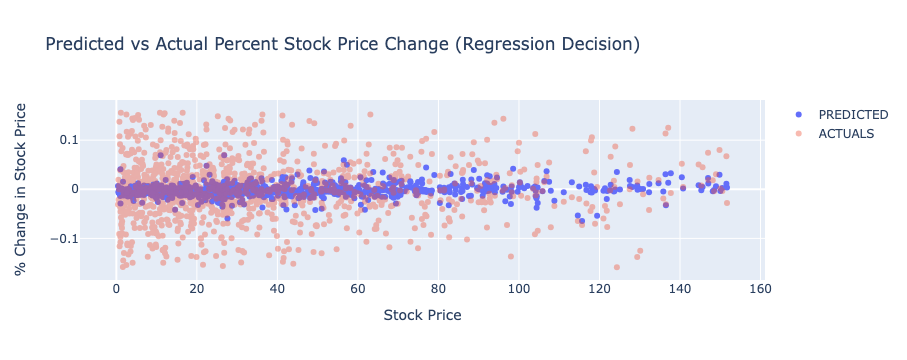

In [101]:
fig = go.Figure()
# fig = px.scatter(eval, x='Close', y='y_eval_pred', opacity = .2) 

# Add traces
fig.add_trace(go.Scatter(x=results_eval['Close'], y=results_eval['y_eval_pred_pct_stock_change'], 
                    mode='markers',
                    name='PREDICTED', ))
fig.add_trace(go.Scatter(x=results_eval['Close'], y=results_eval['Close_pct_change'],opacity = 0.4,
                    mode='markers',
                    name='ACTUALS'))
fig.update_layout(
    title="Predicted vs Actual Percent Stock Price Change (Regression Decision)",
    xaxis_title="Stock Price",
    yaxis_title="% Change in Stock Price")

fig.show()

In [171]:
# export decision tree results to csv 
results_eval.to_csv('predictions/evaluation_data_predictions.csv', index = False)

## Interpretation : 
MAE for train and eval are almost identical between linear regression and decision tree regression. 

In [119]:
mae_dict = {'DTree': [mae_train, mae_eval],
           'LinearReg':[LR_MAE_train, LR_MAE_eval]}
mae_dict

{'DTree': [0.04384850065614829, 0.043927343782194414],
 'LinearReg': [0.04384850065614829, 0.043927343782194414]}

In [164]:
mae_results = pd.DataFrame.from_dict(mae_dict, orient= 'index', columns = ['Train', 'Eval'])

## Optimize Decision Tree

In [127]:
from sklearn.model_selection import GridSearchCV

In [148]:
parameters = {'max_depth': [2, 4, 6, 8], 'max_leaf_nodes': [3,4,6,8,10,12],
             'max_features': [1, 3, 4]}

In [149]:
dt1 = DecisionTreeRegressor()
dt1 = GridSearchCV(dt1, parameters)


In [150]:
dt1.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [2, 4, 6, 8], 'max_features': [1, 3, 4],
                         'max_leaf_nodes': [3, 4, 6, 8, 10, 12]})

In [151]:
dt1.best_params_

{'max_depth': 2, 'max_features': 1, 'max_leaf_nodes': 6}

In [155]:
y_predict_eval = dt1.predict(X_eval)
mae_eval_hp = mean_absolute_error(y_eval, y_predict_eval)
mae_eval_hp

0.045317296455527

In [156]:
y_predict_train = dt1.predict(X_train)
mae_train_hp = mean_absolute_error(y_train, y_predict_train)
mae_train_hp

0.044017998582972416

In [157]:
mae_dict

{'DTree': [0.04384850065614829, 0.043927343782194414],
 'LinearReg': [0.04384850065614829, 0.043927343782194414]}

In [165]:
mae_results

Train      Eval
DTree      0.043849  0.043927
LinearReg  0.043849  0.043927

In [166]:
mae_results.loc['Dtree_tuned', :] = [mae_train_hp, mae_eval_hp]
mae_results

Train      Eval
DTree        0.043849  0.043927
LinearReg    0.043849  0.043927
Dtree_tuned  0.044018  0.045317

## Conclusion: 
* Results of all modelling are equal in performance. The tuned regression tree performing slightly worse. 

# For future:

Thoughts for future and the next iteration of this model :
* look at other stock market features and find stronger linear relationships to use for predictions. Would there be an improvement to the performance of the model if incorporated:
    * premarket or postmarket announcement (as 1 for premarket, 0 for postmarket)
    * month announced
    * day of week announced
* integrate straddle returns into dataset
* Select highest priority stocks to evaluate and develop one one model per stock, integrating time series forecasting 
* 